<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Statistical Modeling and Model Validation

---

## Objective
The goal of this assessment is to guide you through the modeling workflow to produce the best model you can. In this lesson, you will follow all best practices when slicing your data and validating your model. 

Specifically, the following skills will be reinforced in a real-world-ish simulated setting:

For logistic regression:
* Handling categorical features in a `sklean` model.
* Carrying out a train-test-split.
* Training a model.
* Evaluating that model on the testing data.

For k-Nearest Neighbors:
* Preparing your data for modeling.
* Scaling your data.
* Tuning a tuning parameter using k-Fold Cross Validation.
* Finally selecting a model based on a tuning parameter.
* Making model-based decisions on new data.

## Imports

In [113]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# Import everything you need for this project here.
# You will want to return to this cell to import more things later in the project.
# DO NOT COPY AND PASTE FROM OUR CLASS SLIDES!
# Muscle memory is important in this class!

import warnings
warnings.filterwarnings("ignore")

# Part 1: Regression on MPG Data

## Read Data
The `mpg` dataset is the fuel economy for 38 popular models of car between 1999 and 2008

In [114]:
# Read in the mpg data in the data folder in this repository.
mpg = pd.read_csv('./data/mpg.csv')
print('The number of rows & columns, respectively, in this table are =', mpg.shape)
mpg.head()                 

The number of rows & columns, respectively, in this table are = (234, 11)


,manufacturer,model,displ,year,cyl,trans,drv,cty,hwy,fl,class
0,audi,a4,1.8,1999,4,auto(l5),f,18,29,p,compact
1,audi,a4,1.8,1999,4,manual(m5),f,21,29,p,compact
2,audi,a4,2.0,2008,4,manual(m6),f,20,31,p,compact
3,audi,a4,2.0,2008,4,auto(av),f,21,30,p,compact
4,audi,a4,2.8,1999,6,auto(l5),f,16,26,p,compact


## Explore the data
Use this space to familiarize yourself with the data.

Convince yourself there are no issues with the data. If you find any issues, clean them here.

#### Myself: "How's the data and what does the data in critical columns (to be assessed later) look like?"
I've looked the table over and the column data, based on titles, seems reasonable.<br>
In addition, the results of the following two cells suggest that the table has no missing data.<br>
**So, I think the data is fine.**

Two measures of familiarization are shown below (scatter plot for looking at correlation of 'displ' data with 'hwy' & boxplot for comparing the relationships between various 'drv' mechanisms with 'hwy'):
- 'displ' is column with somewhat continuous data which exhibits a fairly good, linear and inverse relationship with 'hwy'
- 'drv' is a column with 3 categories of data (f, r & 4) and when their relationship with 'hwy' is compared, 
    * f appears to have the highest mean 'hwy' correlation
    * r correlates at a value that is much lower than f, but with a mean somewhat higher than 4
    * 4 correlates with the lowest 'hwy' and with a fairly high range of data (deviation)

In [3]:
print("Here's a list of the columns with number of filled data cells in 234 rows:")
mpg.info()

Here's a list of the columns with number of filled data cells in 234 rows:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 11 columns):
manufacturer    234 non-null object
model           234 non-null object
displ           234 non-null float64
year            234 non-null int64
cyl             234 non-null int64
trans           234 non-null object
drv             234 non-null object
cty             234 non-null int64
hwy             234 non-null int64
fl              234 non-null object
class           234 non-null object
dtypes: float64(1), int64(4), object(6)
memory usage: 20.2+ KB


In [4]:
print("Here's a list of the columns with number of empty data cells in 234 rows:")
mpg.isnull().sum()

Here's a list of the columns with number of empty data cells in 234 rows:


manufacturer    0
model           0
displ           0
year            0
cyl             0
trans           0
drv             0
cty             0
hwy             0
fl              0
class           0
dtype: int64

In the following graph, the 'drv' data is aggregated into 3 categories (f, 4 & f) and their mean values, data ranges, and outlier points are shown for comparison.


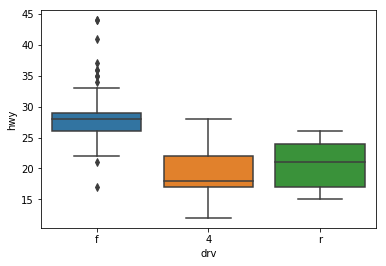

In [5]:
print("In the following graph, the 'drv' data is aggregated into 3 categories (f, 4 & f) and their mean values, data ranges, and outlier points are shown for comparison.")
sns.boxplot(data=mpg, x='drv', y='hwy');

In the following graph, the data shows that 'displ' data exhibits a fairly good, linear and inverse relationship with 'hwy'.


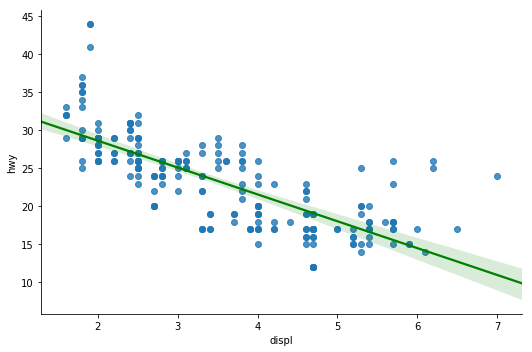

In [6]:
print("In the following graph, the data shows that 'displ' data exhibits a fairly good, linear and inverse relationship with 'hwy'.")
sns.lmplot(x='displ', y='hwy', data=mpg, aspect=1.5, line_kws={'color':'green'});

## Dummify the `drv` Variable

In [7]:
mpg.drv.unique()

array(['f', '4', 'r'], dtype=object)

In [8]:
mpg_dummies = pd.get_dummies(mpg.drv, prefix='drv')
mpg_dummies.sample(n=8, random_state=1)

,drv_4,drv_f,drv_r
199,1,0,0
69,1,0,0
233,0,1,0
39,0,1,0
138,1,0,0
174,1,0,0
90,0,0,1
67,1,0,0


In [9]:
# Concatenate the original DataFrame and the dummy DataFrame.
mpg_dummies = pd.concat([mpg, mpg_dummies], axis=1)

# Print five random rows, just to check it out....
mpg_dummies.sample(n=5, random_state=1)

,manufacturer,model,displ,year,cyl,trans,drv,cty,hwy,fl,class,drv_4,drv_f,drv_r
199,toyota,land cruiser wagon 4wd,5.7,2008,8,auto(s6),4,13,18,r,suv,1,0,0
69,dodge,ram 1500 pickup 4wd,4.7,2008,8,manual(m6),4,9,12,e,pickup,1,0,0
233,volkswagen,passat,3.6,2008,6,auto(s6),f,17,26,p,midsize,0,1,0
39,dodge,caravan 2wd,3.3,1999,6,auto(l4),f,16,22,r,minivan,0,1,0
138,mercury,mountaineer 4wd,4.0,2008,6,auto(l5),4,13,19,r,suv,1,0,0


In [10]:
# Get rid of unnecessary columns for production of the model.
mpg_dummies.drop(['manufacturer', 'model', 'year', 'cyl', 'trans', 'drv', 'drv_4','cty', 'fl', 'class'], axis=1, inplace=True)

In [11]:
# Display the columns for the data below.
mpg_dummies.head()

,displ,hwy,drv_f,drv_r
0,1.8,29,1,0
1,1.8,29,1,0
2,2.0,31,1,0
3,2.0,30,1,0
4,2.8,26,1,0


## Split your data into train/test data
You only need to keep the `displ` and `drv` variable(s) here, as those are the only columns you'll be fitting your model on in the next section.

Look at the size of your data. What is a good proportion for your split? **Justify your answer.**

**NOTE:** When doing your train/test split, please use random seed 123.

#### Explanation
It looks like most people use between 90/10 and 70/30 depending upon the amount of data in the dataset. Ours has 234 values.<br> 
I ran the below training/test set linear regression loop - changing the 'test_size' variable and recording the corresponding RMSE value.<br>
While the 94/6 split's RMSE appears to be the lowest, this would only include 14 test set points.<br>
So, I'd opt for a 79/21 split which is the biggest drip while still maintaining the highest number of test set points at 49.<br>
For future purposes....I'll just include it as an 80/20 split (test_size=0.20).

In [12]:
# Create X and y.
FEATURE_COLS = ['displ', 'drv_f', 'drv_r']
X = mpg_dummies[FEATURE_COLS]
y = mpg_dummies.hwy

# Create training and test sets at various ratios (test_sizes) and calculate the RMSE for each regression for each.
for i in range(1, 40, 5):
    t = i/100
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t, random_state=123)

    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    
    y_pred = linreg.predict(X_test)
    print((round((1-t)*100)), '/', (round(t*100)), 'split, with the resulting RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
    print("\t", (round((1-t)*234)), 'training set points &', (round(t*234)), 'test set points')

99 / 1 split, with the resulting RMSE: 2.6055986316231117
	 232 training set points & 2 test set points
94 / 6 split, with the resulting RMSE: 2.44621161034661
	 220 training set points & 14 test set points
89 / 11 split, with the resulting RMSE: 2.501489713765131
	 208 training set points & 26 test set points
84 / 16 split, with the resulting RMSE: 2.6476393100732163
	 197 training set points & 37 test set points
79 / 21 split, with the resulting RMSE: 2.681676275077574
	 185 training set points & 49 test set points
74 / 26 split, with the resulting RMSE: 3.3267455780402426
	 173 training set points & 61 test set points
69 / 31 split, with the resulting RMSE: 3.2036802619715488
	 161 training set points & 73 test set points
64 / 36 split, with the resulting RMSE: 3.378211877497126
	 150 training set points & 84 test set points


## Fit a Linear Regression model predicting Highway MPG
You must use exactly these two variables: `displ` and `drv`.

In [13]:
# Set X and y.
FEATURE_COLS = ['displ']
X = mpg_dummies[FEATURE_COLS]
y = mpg_dummies.hwy

# Create 80/20 training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

# Instantiate the linear regression model.
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred = linreg.predict(X_test)

# Print the coefficients.
print('intercept =', linreg.intercept_)
print("slope =", linreg.coef_)

intercept = 36.41351848951142
slope = [-3.72600879]


## Evaluate your model
Look at some evaluation metrics for **both** the training and test data. How did your model do? Is it overfit, underfit, or neither?

#### How'd the model do?
Based on the mse & rmse data for training set and testing set - the model is pretty equivalent for each.<br>
The slightly larger Training set has slightly larger values than the smaller Training set, which is not unusual for data with a fairly high data deviation and some outliers.<br>
The graph below, with blue/cyan data points and green prediction line, displays the information for a visual comparison.<br>
The data distribution for both datasets and the linear regression prediction appear to fit well.

In [14]:
print('Model Mean Square Errors for the:')
print('Training Set =', mean_squared_error(linreg.predict(X_train), y_train))
print('Testing Set =', mean_squared_error(linreg.predict(X_test), y_test))

print('\nModel Root Mean Square Errors for the:')
print('Training Set =', np.sqrt(mean_squared_error(linreg.predict(X_train), y_train)))
print('Testing Set =', np.sqrt(mean_squared_error(linreg.predict(X_test), y_test)))

Model Mean Square Errors for the:
Training Set = 15.23583851627303
Testing Set = 12.33844465628183

Model Root Mean Square Errors for the:
Training Set = 3.9033112246236565
Testing Set = 3.512612226859354


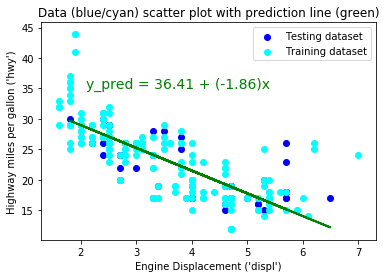

In [15]:
plt.scatter(X_test, y_test,  color='blue', label='Testing dataset')
plt.scatter(X_train, y_train,  color='cyan', label='Training dataset')
plt.plot(X_test, y_pred, color='green', linewidth=2)
plt.title('Data (blue/cyan) scatter plot with prediction line (green)')
plt.ylabel("Highway miles per gallon ('hwy')")
plt.xlabel("Engine Displacement ('displ')")
plt.legend(loc='upper right');
plt.text(2.1, 35, "y_pred = 36.41 + (-1.86)x", color='green', size=14)
plt.show()

# Part 2: Classification using KNN

## Read in the Diamonds data
This is data regarding 50,000 round cut diamonds.

In [16]:
diamonds = pd.read_csv('./data/diamonds.csv')

## Explore the data

In [17]:
diamonds.shape

(53940, 10)

In [18]:
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
carat      53940 non-null float64
cut        53940 non-null object
color      53940 non-null object
clarity    53940 non-null object
depth      53940 non-null float64
table      53940 non-null float64
price      53940 non-null int64
x          53940 non-null float64
y          53940 non-null float64
z          53940 non-null float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [19]:
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## Filter your data
Filter your data to only contain diamonds of cuts "Ideal" and "Good"

In [49]:
filtered_diamonds = diamonds.loc[diamonds['cut'].isin(['Ideal','Good'])]
filtered_diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
10,0.30,Good,J,SI1,64.0,55.0,339,4.25,4.28,2.73
11,0.23,Ideal,J,VS1,62.8,56.0,340,3.93,3.90,2.46


## Prepare your X, y matrices
Construct an `X` matrix using **all numeric columns** from the diamond data.

You will be predicting `cut`. Construct a `y` vector in a numeric format that can be used by scikit-learn.

In [50]:
# Create feature matrix (X) and a response vector (y).
FEATURE_COLS = ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']
X = filtered_diamonds[FEATURE_COLS]
y = filtered_diamonds.cut

print('Y-values =', y.shape)
print('X-values rows & columns =', X.shape)
X.head()

Y-values = (26457,)
X-values rows & columns = (26457, 7)


,carat,depth,table,price,x,y,z
0,0.23,61.5,55.0,326,3.95,3.98,2.43
2,0.23,56.9,65.0,327,4.05,4.07,2.31
4,0.31,63.3,58.0,335,4.34,4.35,2.75
10,0.30,64.0,55.0,339,4.25,4.28,2.73
11,0.23,62.8,56.0,340,3.93,3.90,2.46


## Scale your X matrix using a Standard Scaler

Take a look at the axes of each of these column histograms.
Note that the actual values and distribution.


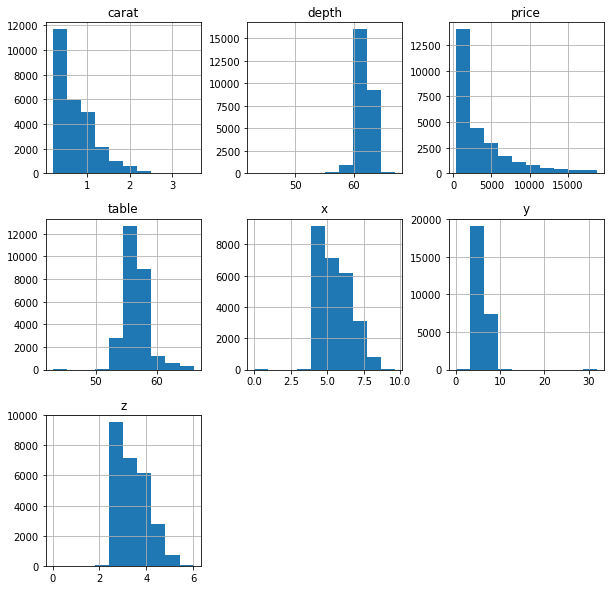

In [51]:
print('Take a look at the axes of each of these column histograms.')
print('Note that the actual values and distribution.')
X.hist(figsize=(10, 10));

In [52]:
print('Before scaling:')
filtered_diamonds.describe()

Before scaling:


,carat,depth,table,price,x,y,z
count,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000
mean,0.729975,61.831134,56.460305,3544.940696,5.568891,5.581396,3.445592
std,0.440559,1.165414,1.977192,3789.568408,1.070685,1.077944,0.663607
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.360000,61.300000,55.000000,895.000000,4.600000,4.610000,2.840000
50%,0.570000,61.900000,56.000000,1949.000000,5.330000,5.340000,3.280000
75%,1.010000,62.400000,57.000000,4770.000000,6.430000,6.440000,3.990000
max,3.500000,67.000000,66.000000,18806.000000,9.650000,31.800000,6.030000


In [115]:
# Use the StandardScaler() function to convert the values into non-unitized distributions
scaler = StandardScaler()
scaler.fit(X)
Xscaled = scaler.transform(X)

Note that all data can now be shown on a single histogram with the x-axis distribution as very narrow.


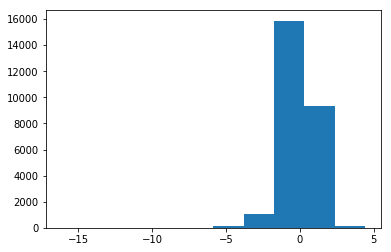

In [54]:
print('Note that all data can now be shown on a single histogram with the x-axis distribution as very narrow.')
plt.hist(Xscaled[:,1]);

In [55]:
print('After scaling:')
pd.DataFrame(Xscaled).describe()

After scaling:


,0,1,2,3,4,5,6
count,2.645700e+04,2.645700e+04,2.645700e+04,2.645700e+04,2.645700e+04,2.645700e+04,2.645700e+04
mean,9.836880e-15,6.136843e-15,-1.225669e-14,2.223069e-16,-4.182749e-15,-3.660987e-15,1.648061e-14
std,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00
min,-1.202982e+00,-1.615862e+01,-6.807917e+00,-8.494375e-01,-5.201340e+00,-5.177916e+00,-5.192314e+00
25%,-8.397999e-01,-4.557552e-01,-7.385894e-01,-6.992856e-01,-9.049435e-01,-9.011735e-01,-9.125933e-01
50%,-3.631241e-01,5.909295e-02,-2.328120e-01,-4.211484e-01,-2.231240e-01,-2.239453e-01,-2.495380e-01
75%,6.356253e-01,4.881330e-01,2.729653e-01,3.232776e-01,8.042751e-01,7.965356e-01,8.203922e-01
max,6.287639e+00,4.435302e+00,4.824961e+00,4.027199e+00,3.811753e+00,2.432326e+01,3.894558e+00


## Why did we just do that?
In the cell below, give a 2-3 sentence explanation of why scaling our $X$ matrix was necessary here. What could have gone wrong if we didn't?

#### Because
It is because column data are measured in widely divergent scales:
- price data measures in the thousands
- depth and table in the middle-teens
- x , y & z in the single digits
- carats are generally in decimals

So, without scaling, the resulting model would be heavily skewed based on biased data.<br>
*Scaling converts these variables into a single proportional unitless scale for comparison.*

## k-Nearest Neighbors
You're going to fit a kNN model here, but you first need to tune your model to find the best value of $k$. Loop through the suggested values of $k$ and select the value that produces the best model with respect to **5-fold cross-validation**.


**IMPORTANT:** Do not use _any_ code copy and pasted directly from lecture! Typing things out yourself is 100% essential to the learning process here. It's ok to use the exact same strategies used in class, just _please please please_ type it our yourself!

**IMPORTANT 2:** Make sure your 5-fold CV is selecting folds randomly (ie, `shuffle=True`)

In [76]:
# Loop through the values of k in range(1, 51)
# NOTE: This could take several minutes on your computer! Make sure you have all of your
# code correct before running the cell. If you're unsure, test your code on a smaller 
# array of ks first.

# Create the loop for incrementally increasing k value
k_range = list(range(1, 51))

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(Xscaled, y, test_size=0.20, random_state=123)

# Set up a list to save the accuracy scores
training_error = []
training_accuracy = []
testing_error = []
testing_accuracy = []
k_values = []

# Find accuracy for all values of k between 1 and 51.
for k in k_range:

    # Instantiate the model with the current K value.
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
        
    # Calculate training accuracy & error, append to lists 
    y_pred_train = knn.predict(X_train)
    training_accuracy.append(accuracy_score(y_train, y_pred_train))
    training_error.append(accuracy_score(y_train, y_pred_train))
    
    # Calculate testing error accuracy & error, append to lists
    y_pred_test = knn.predict(X_test)
    testing_accuracy.append(accuracy_score(y_test, y_pred_test))
    testing_error.append(accuracy_score(y_test, y_pred_test))
    
    # Save the k value, save to list
    k_values.append(k)

# Tell me when this is over!    
print('done')

done


In [77]:
# Create a DataFrame with corresponding k and accuracy data.
column_dict = {'k' : k_values, 'training accuracy' : training_accuracy, 'training error': training_error, 'testing accuracy': testing_accuracy, 'testing error': testing_error}
k_accuracy = pd.DataFrame(column_dict).sort_index(ascending=False)
k_accuracy.head()

,k,training accuracy,training error,testing accuracy,testing error
49,50,0.978185,0.978185,0.974427,0.974427
48,49,0.977861,0.977861,0.973797,0.973797
47,48,0.978401,0.978401,0.973797,0.973797
46,47,0.978131,0.978131,0.973167,0.973167
45,46,0.978617,0.978617,0.973419,0.973419


## Produce the plot of tuning parameter (k) vs Accuracy
What is the "best" value of k?

In [78]:
print('Based on the best testing accuracy, these are the ideal values:')
k_accuracy.loc[k_accuracy['testing accuracy'].idxmax()]

Based on the best testing accuracy, these are the ideal values:


k                    9.000000
training accuracy    0.983206
training error       0.983206
testing accuracy     0.977954
testing error        0.977954
Name: 8, dtype: float64

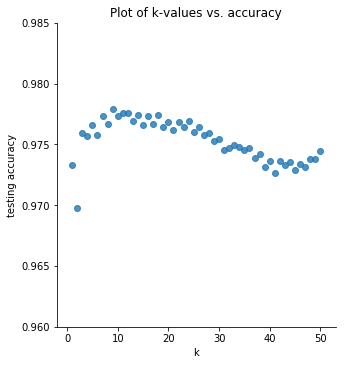

In [81]:
# Plot of k-value vs. accuracy
sns.lmplot(data=k_accuracy, x='k', y='testing accuracy', fit_reg=False);
plt.title('Plot of k-values vs. accuracy');
plt.ylim(0.96, 0.985);

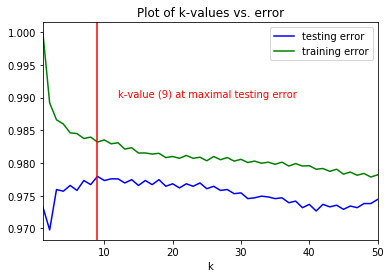

In [82]:
# Plot the relationship between k and testing error.
ax = k_accuracy.plot(kind="line", x='k', y='testing error', color='b', label='testing error');
k_accuracy.plot(x='k', y='training error', color='g', label='training error', ax=ax);
plt.axvline(x=9, color='r')
plt.annotate('k-value (9) at maximal testing error', xy=(12, 0.99), color='r', xycoords='data')
plt.title('Plot of k-values vs. error');

## Produce the Best kNN Model
Now that you know the optimal value of k, fit a kNN on the full (but still filtered to "Ideal" and "Good" cuts)

In [83]:
# Redo the model using the value found above - k=14.
knn = KNeighborsClassifier(n_neighbors = 9)

# Redo the training with the full dataset
knn.fit(X, y)
y_pred = knn.predict(X)

print('This model has an accuracy score of', accuracy_score(y, y_pred))

This model has an accuracy score of 0.8725857051063991


## Does this model outperform the baseline?

#### Answer(ish)
*If* the value above is true and the value generated below based on values is true,<br>
then....yup....87% is better than 18.5%.

In [84]:
# Compute the baseline model accuracy
filtered_diamonds.groupby('cut').count()
num_good = len(filtered_diamonds[filtered_diamonds.cut == 'Good'] )
num_ideal = len(filtered_diamonds[filtered_diamonds.cut == 'Ideal'])
#print(num_good)
#print(num_ideal)
baseline_accuracy = num_good/(num_good+num_ideal)

print('Baseline accuracy is:', baseline_accuracy)
print('Best kNN Model accuracy (from above) is:', accuracy_score(y, y_pred))

Baseline accuracy is: 0.18543296670068413
Best kNN Model accuracy (from above) is: 0.8725857051063991


## Prediction
Suppose I have a diamond with the following specifications:

In [85]:
new_diamond = pd.DataFrame({
    'carat': 0.24,
    'depth': 60,
    'table': 64,
    'price': 400,
    'x': 3,
    'y': 3,
    'z': 3
}, index=[0])

What do you predict the cut of this diamond to be?

**BIG HINT:** Don't forget to scale this new data point appropriately!

In [116]:
X_new = scaler.transform(new_diamond)
print('The new prediction is', knn.predict(X_new), '!')

The new prediction is ['Good'] !


# Part 3: Now _YOU_ Model!

#### Well.....
Since we haven't really done logistic regression yet, I'll skip this for now.

Put your skills to the test

Using the _full_ diamonds data set, produce a **logistic regression** model that achieves the best randomzied 20-fold cross validation. Note that for this problem, you are doing multi-class classification. The response variable has _five_ categories.

In [121]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

In [92]:
# Retrieving the full diamonds dataset and re-familiarizing myself withe the file and file structure
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [134]:
# Create feature matrix (X) and a response vector (y).
FEATURE_COLS = ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']
X = diamonds[FEATURE_COLS]
y = diamonds.cut

# Use the StandardScaler() function to convert the values into non-unitized distributions
scaler = StandardScaler()
scaler.fit(X)
Xscaled = scaler.transform(X)

# using train test split
X_train, X_test, y_train, y_test = train_test_split(Xscaled, y, random_state=123)

# fit model
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)

# make predictions with test data
y_pred = logreg.predict(X_test)

# assess for accuracy
print('Accuracy score =', metrics.accuracy_score(y_test, y_pred))
print('20-fold cross-validation score =', np.mean(cross_val_score(logreg, Xscaled, y, cv=20)))

Accuracy score = 0.6476826103077493
20-fold cross-validation score = 0.6445630478359601


In [130]:
X_new = scaler.transform(new_diamond)
print('With the full diamond dataset, the new prediction based on logistic regression is', logreg.predict(X_new), '!')
print('Which will make the seller happy....;-)')

With the full diamond dataset, the new prediction based on logistic regression is ['Very Good'] !
Which will make the seller happy....;-)
